## Imports

In [14]:
import scipy.io
import numpy as np
from tqdm import tqdm # for nice progress bars
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from scipy.stats import linregress
from sklearn.model_selection import KFold
from statsmodels.sandbox.stats.multicomp import multipletests 
import warnings # to silence convergence warnings

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set_theme() # Set searborn as default

## Load dataset

In [5]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape

### 2 Find an elastic net solution for the sand data, with suitable choices of regression parameters using cross validation.

>(a) Use the coordinate descent algorithm.

>>(i) Python: Use Python’s `linear_model.ElasticNet`.

>(b) Investigate how different values of α affects the number of nonzero parameters in the coordinate descent algorithms.
  
>(c) What are the pros and cons of the coordinate descent algorithm compared to using LARS?

....................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s finished


Text(0.5, 1.0, 'Crossvalidated MSE of Elastic Net Fit Alpha = 0.00')

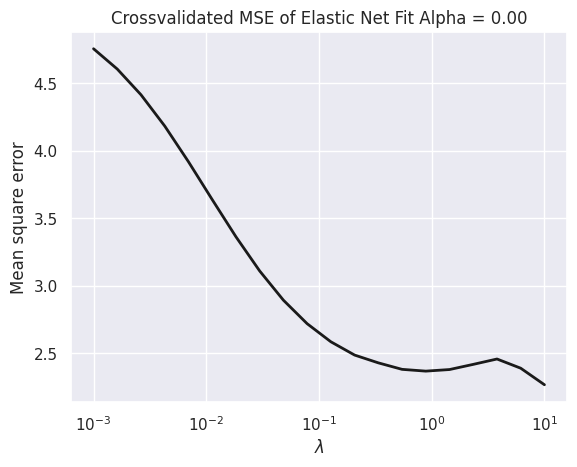

In [8]:
# set up a range of lambdas and an alpha value
alpha = 0.001
lambdas = np.logspace(-3, 1, num=20)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")

    #Run the elasticNet model. You can implement Crossvalidation yourself or look at ElasticNetCV
    model = linear_model.ElasticNetCV(l1_ratio=alpha, alphas=lambdas, cv=5, fit_intercept=False, verbose=True)
    model.fit(X, y)
    
plt.figure()
plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean square error')
plt.title('Crossvalidated MSE of Elastic Net Fit Alpha = %.2f' % alpha)

9it [01:10,  7.85s/it]


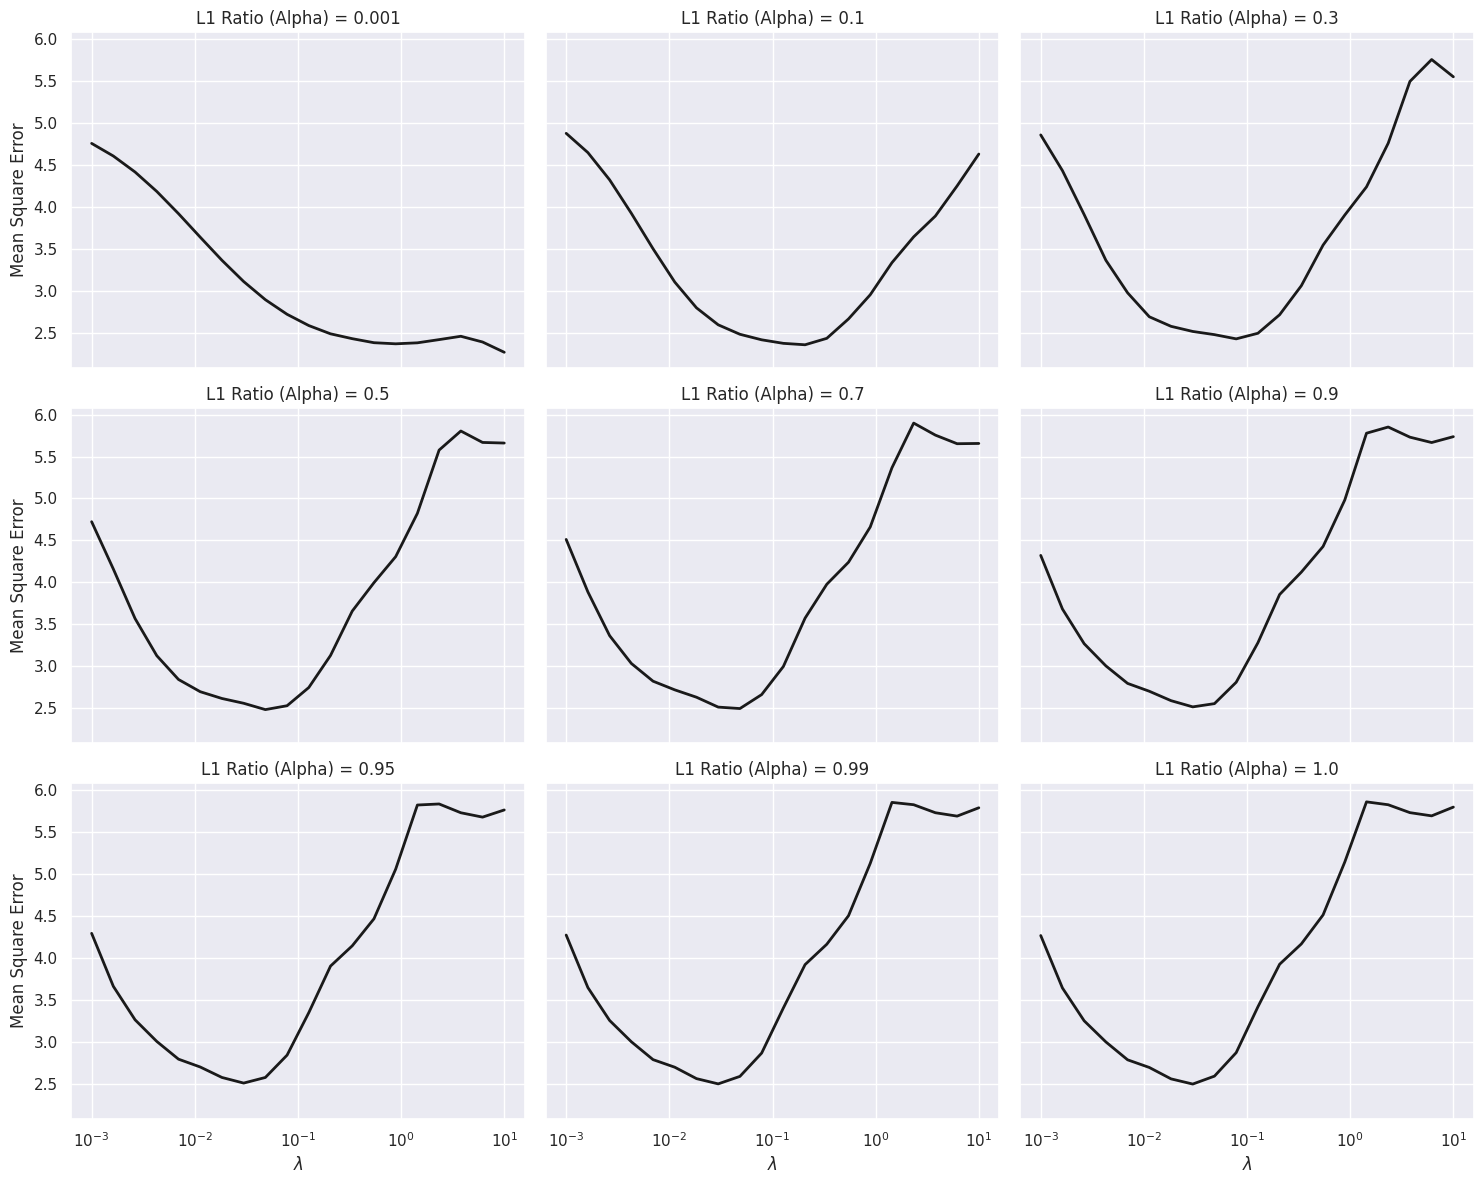

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings

# Define your hyperparameter ranges
l1_ratios = [0.001, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0] # 9 values for a 3x3 grid
lambdas = np.logspace(-3, 1, num=20)

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten() # Flatten to loop easily

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i, ratio in tqdm(enumerate(l1_ratios)):
        # Initialize and fit the CV model for each ratio
        model = linear_model.ElasticNetCV(
            l1_ratio=ratio, 
            alphas=lambdas, 
            cv=5, 
            fit_intercept=False
        )
        model.fit(X, y)
        
        # Plotting on the specific subplot
        ax = axes[i]
        # model.mse_path_ shape is (n_alphas, n_folds)
        mse_mean = model.mse_path_.mean(axis=-1)
        
        ax.semilogx(model.alphas_, mse_mean, 'k', linewidth=2)
        ax.set_title(f'L1 Ratio (Alpha) = {ratio}')
        
        if i >= 6: 
            ax.set_xlabel(r'$\lambda$')
        if i % 3 == 0: 
            ax.set_ylabel('Mean Square Error')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sum of coefficients of Elastic Net Fit Alpha = 0.00')

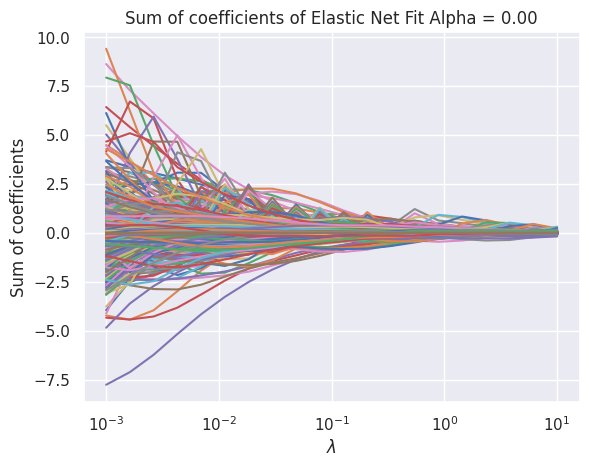

In [11]:
#To look at the coefficients we need to implement CV ourselves
CV = 5
kf = KFold(n_splits=CV)

coefs = np.zeros((CV,len(lambdas),p))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for j, lambda_ in enumerate(lambdas):
        with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
            warnings.simplefilter("ignore")

            #Run the elasticNet model.
            model = linear_model.ElasticNet(alpha=lambda_, l1_ratio=alpha, fit_intercept=False)
            model.fit(X_train, y_train)
            coefs[i,j,:] = model.coef_
        
trace = np.sum(coefs, axis=0)

plt.figure()
plt.semilogx(lambdas, trace)
plt.xlabel(r'$\lambda$')
plt.ylabel('Sum of coefficients')
plt.title('Sum of coefficients of Elastic Net Fit Alpha = %.2f' % alpha)

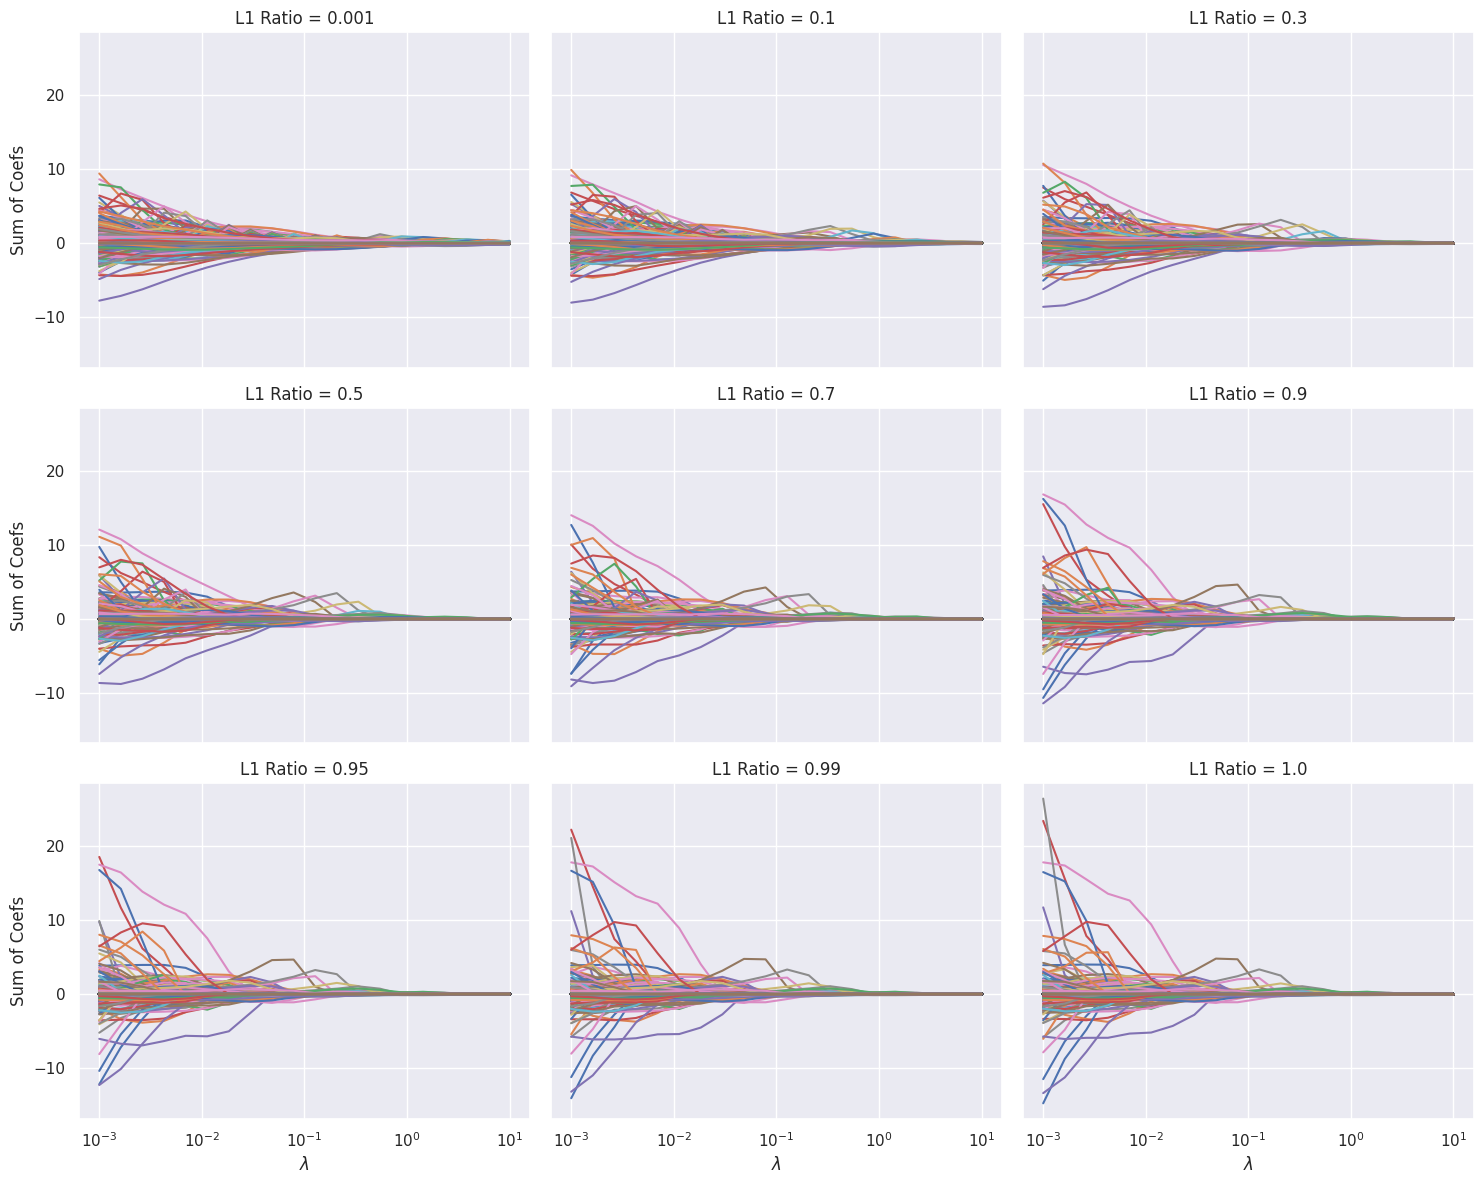

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
import warnings

# Configuration
l1_ratios = [0.001, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
lambdas = np.logspace(-3, 1, num=20)
CV = 5
p = X.shape[1] 

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

kf = KFold(n_splits=CV)

for idx, ratio in tqdm(enumerate(l1_ratios)):
    # Reset coefs for each L1 ratio iteration
    coefs = np.zeros((CV, len(lambdas), p))
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, y_train = X[train_index], y[test_index] # Fixed: matching indices
        
        for j, lambda_ in enumerate(lambdas):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # In sklearn, alpha is the penalty weight (lambda) 
                # and l1_ratio is the Elastic Net mixing parameter
                model = linear_model.ElasticNet(alpha=lambda_, l1_ratio=ratio, fit_intercept=False)
                model.fit(X[train_index], y[train_index])
                coefs[i, j, :] = model.coef_
    
    # Calculate the trace (sum across folds)
    trace = np.sum(coefs, axis=0)
    
    # Plotting
    ax = axes[idx]
    ax.semilogx(lambdas, trace)
    ax.set_title(f'L1 Ratio = {ratio}')
    
    if idx >= 6:
        ax.set_xlabel(r'$\lambda$')
    if idx % 3 == 0:
        ax.set_ylabel('Sum of Coefs')

plt.tight_layout()
plt.show()